### Gradient boost tree implementation

Let's try to implement GBDT with hands-on data

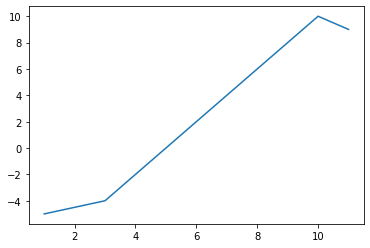

In [1]:
import numpy as np
import matplotlib.pyplot as plt

data = np.array([1, 3, 10, 11])
label = np.array([-5, -4, 10, 9])

plt.plot(data, label)

In [17]:
def gain(res, la=1):
    return np.sum(res)**2 / (len(res) + la)

base_gain = gain(label)

print("Root base gain: ", base_gain)



Root base gain:  20.0


In [18]:
# sort data and label with index, so could get interval data to compare to decide which feature to split
sort_index = np.argsort(data)

data = data[sort_index]
label = label[sort_index]

In [19]:
# get data split interval with mean value
interval_list = [(data[i] + data[i+1])/2 for i in range(len(data)-1)]

# each tree with init guess to be 0.5 for both classification and regression.
base_guess = .5
residual = label - base_guess

# loop for each interval to get gain value
gain_list = []
for interval in interval_list:
    left_res = residual[data <= interval]
    right_res = residual[data > interval]
    
    left_gain = gain(left_res)
    right_gain = gain(right_res)
    interval_gain = left_gain + right_gain - base_gain
    gain_list.append(interval_gain)

print(gain_list)
# largest gain should be point to split
split_value = interval_list[np.argmax(gain_list)]

print("Split value:", split_value)
print("Original data:", data)


[40.6875, 121.33333333333334, 16.1875]
Split value: 6.5
Original data: [ 1  3 10 11]


In [20]:
print("Tree")
print(data)
print(data[data < split_value],data[data >= split_value], sep='\t')


Tree
[ 1  3 10 11]
[1 3]	[10 11]


In [23]:
# try to get output prediction
left_res = residual[data <= split_value]
right_res = residual[data > split_value]

left_leaf_pred = np.sum(left_res)
right_leaf_pred = np.sum(right_res)

print(left_leaf_pred, right_leaf_pred)

-10.0 18.0


In [26]:
# if data go to left, then prediction will be: 0.5 + learning_rate * pred
learning_rate = .3

left_pred = 0.5 + learning_rate * left_leaf_pred
right_pred = .5 + learning_rate * right_leaf_pred

print(left_pred, right_pred)

-2.5 5.8999999999999995


In [27]:
# to get each data point to get output result
pred = []
for x in data:
    if x <= split_value:
        p = left_pred
    else:
        p = right_pred
    pred.append(p)

print(pred)

[-2.5, -2.5, 5.8999999999999995, 5.8999999999999995]


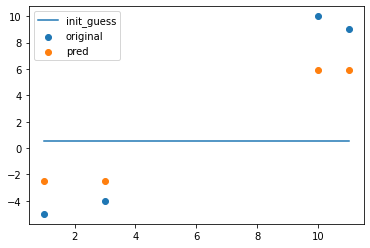

In [30]:
# plot original data and prediction data
plt.scatter(data, label, label='original')
plt.scatter(data, pred, label='pred')
plt.plot(data, [.5]*len(data), label='init_guess')

plt.legend()
plt.show()

### Noted:
Also there is a parameter with gamma, if gain is less than gamma, will be revert 2 leaves into one leaf, min_child_weight is a regulation parameter, if leaf gain is less then cover, then leaf will be removed


# Classification

No handles with labels found to put in legend.


Shouldn't spilt to right
Shouldn't split to left
Shouldn't spilt to right
Shouldn't split to left
Build tree
[ 1  4  5 10]
[1]	[ 4  5 10]
Tree Finished
Left cover is over init? False
Right cover is over init? False
get out list: [1.0, 0.3333333333333333]
[0.31002551887238755, 0.35434369377420455, 0.35434369377420455, 0.35434369377420455]


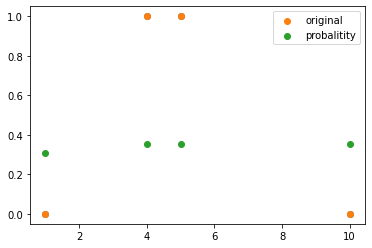

In [62]:
# Let's check with classification
import numpy as np
import matplotlib.pyplot as plt

data = np.array([1, 4, 5, 10])
label = np.array([0, 1, 1, 0])

# sort data
index = np.argsort(data)
data = data[index]
label = label[index]

# plot data
plt.scatter(data, label)
plt.legend()

# define gain func
def classification_gain(res, prob, la=0):
    return np.sum(res)**2/(np.sum(prob * (1-prob)) + la)

# get data interval
interval_list = [(data[i]+ data[i+1])/2 for i in range(len(data)-1)]

# compute residual
init_guess = .5
residual = label - init_guess

# init probability
prob = np.array([init_guess] * len(data))
init_gain = classification_gain(residual, prob)

# get cover, if cover is over min_child_split, then remove that leaf
init_cover = 2
init_gamma = 1

def _get_cover(prob, la=0):
    return np.sum(prob * (1 - prob)) - la

# loop for each interval to compute gain
def _get_logic_not(sati):
    return np.logical_not(sati)

gain_list = []
for interval in interval_list:
    left_sati = data <= interval
    left_gain = classification_gain(residual[left_sati], prob[left_sati])
    right_gain = classification_gain(residual[_get_logic_not(left_sati)], prob[_get_logic_not(left_sati)])

    if left_gain < init_gamma:
        print("Shouldn't split to left")
    if right_gain < init_gamma:
        print("Shouldn't spilt to right")
    
    gain_list.append(left_gain + right_gain - init_gain)

# get max gain with  interval list to get split data
split_data= interval_list[np.argmax(gain_list)]

# print tree
left_sati = data <= split_data
print("Build tree")
print(data)
print(data[left_sati], data[_get_logic_not(left_sati)], sep='\t')
print("Tree Finished")


# computer left cover and right to decide to prune or not
left_cover = _get_cover(prob[left_sati])
right_cover =_get_cover(prob[_get_logic_not(left_sati)])
print("Left cover is over init?", left_cover > init_cover)
print("Right cover is over init?", right_cover > init_cover)


# get output with log(odds)
def log_odds(x):
    return np.log(x / (1-x))

def probability(odds):
    return np.exp(-odds) / (1 + np.exp(-odds))

# compuate output for each leaf
left_sati = data <= split_data
left_output = classification_gain(residual[left_sati], prob[left_sati])
right_output = classification_gain(residual[_get_logic_not(left_sati)], prob[_get_logic_not(left_sati)])
out_list = [left_output, right_output]

print("get out list:", out_list)
# get prob
learning_rate = .3

prob_list = []
for x in data:
    if x <= split_data:
        out = out_list[0]
    else:
        out = out_list[1]
    p = init_guess + learning_rate * out
    prob_list.append(probability(p))

print(prob_list)


# plot original and prediction
plt.scatter(data, label, label='original')
plt.scatter(data, prob_list, label='probalitity')
plt.legend()

plt.show()


In [49]:
residual

array([-0.5,  0.5,  0.5, -0.5])

In [50]:
left_sati

False